###EV TECHNOLOGIES

In [1]:
!aws sso login 

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://wipo.awsapps.com/start/#/device

Then enter the code:

RFLW-SSRL
Successfully logged into Start URL: https://wipo.awsapps.com/start/


In [2]:
import awswrangler as wr

In [3]:
db='tmpdatabase' # when querying deda_ingestion_prd_link remember to set tmpdatabase for cache issues
sql='SELECT * FROM "landscaperdb"."landscaper_patstat_ext" limit 10;'
df = wr.athena.read_sql_query(sql=sql,database=db) 
df.head() 

,appln_id,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_original,ipr_type,receiving_office,internat_appln_id,...,load_date,appt_ctry_code,invt_ctry_code,appln_title_lg,appln_title,appln_abstract_lg,appln_abstract,ipc_class_symbol,ipc_position,cpc_class_symbol
0,21481680,GB,0517917,A,2005-09-03,2005,GB0517917,PI,,0,...,2025-05-15,[ ],None,[en],[A bait box],None,None,"[A01M 23/24, A01M 23/30, A01M 31/00]","[ , , ]","[A01M 23/245, A01M 23/30, A01M 31/002]"
1,21481689,GB,0517926,A,2005-09-02,2005,GB0517926,PI,,0,...,2025-05-15,[CH],"[ , , , , , , , ]",[en],[Human machine interface for measurement instr...,[en],[A measuring instrument with a human-machine i...,"[G06F 3/00, G06F 3/023, G06F 3/048]","[F, L, ]","[G05B2219/23147, G05B2219/25006, G06F 3/0484..."
2,21481736,GB,0517973,A,2004-02-03,2004,GB0517973,PI,,17461198,...,2025-05-15,[GB],[GB],[en],[Orthopaedic cement mixing device],[en],[An orthopaedic cement mixing apparatus compri...,"[A61B 19/02, A61F 2/46, B01F 7/00, B01F ...","[ , , , , , , ]","[A61B 17/8827, A61B 17/8833, A61B2017/8838, ..."
3,21481773,GB,0518011,A,2005-09-03,2005,GB0518011,PI,,0,...,2025-05-15,[ ],None,[en],[Smoke alarm covers (fire resistance)],None,None,None,None,None
4,21481872,GB,0518114,A,2005-09-06,2005,GB0518114,PI,,0,...,2025-05-15,[GB],"[GB, GB, GB, GB]",[en],[Ester slip agents],[en],[A composition comprises at least two esters h...,"[C08K 5/101, C08L 67/00]","[F, L]","[C08K 5/101, C08K2201/014, C08L 67/00]"


### EV TECHNOLOGIES

In this case, I selecting those patents that have at least tagged with the IPC code B60L 11. Electric propulsion with power supplied within the vehicle.
I am following tis paper: https://doi.org/10.1016/S0172-2190(01)00065-5. Also this paper found that B60L 11 is one the most important codes for EV tech: https://doi.org/10.1007/s10668-023-04011-4 

##counting

In [5]:
sql="""
SELECT 
    SUBSTR(earliest_filing_date, 1, 4) AS filing_year,
    fam_ipc_cpc,
    COUNT(earliest_filing_id) AS family_count
FROM 
    "landscaperdb"."landscaper_family_ext"
WHERE
    any_match (fam_ipc_cpc, x -> x LIKE '%B60L  11%')
GROUP BY 
    earliest_filing_date, 
    fam_ipc_cpc
ORDER BY 
    filing_year, 
    fam_ipc_cpc """

db='tmpdatabase' # when querying deda_ingestion_prd_link remember to set tmpdatabase for cache issues
df = wr.athena.read_sql_query(sql=sql,database=db) 
df.head() 

,filing_year,fam_ipc_cpc,family_count
0,2015,"[B60L 11/00, B60L 11/18, H02J 7/00, E04H ...",1
1,2015,"[B60L 11/00, B60L 11/18, H02J 7/00, H02J ...",1
2,2015,"[B60L 11/00, B60L 11/18, H02J 7/00, Y02T ...",1
3,2015,"[B60L 11/00, B60L 11/18, H02J 7/00, Y02T ...",1
4,2015,"[B60L 11/00, B60L 11/18, H02J 7/14, Y02T ...",1


##SIMPLE COUNTING AND CUMULATIVE

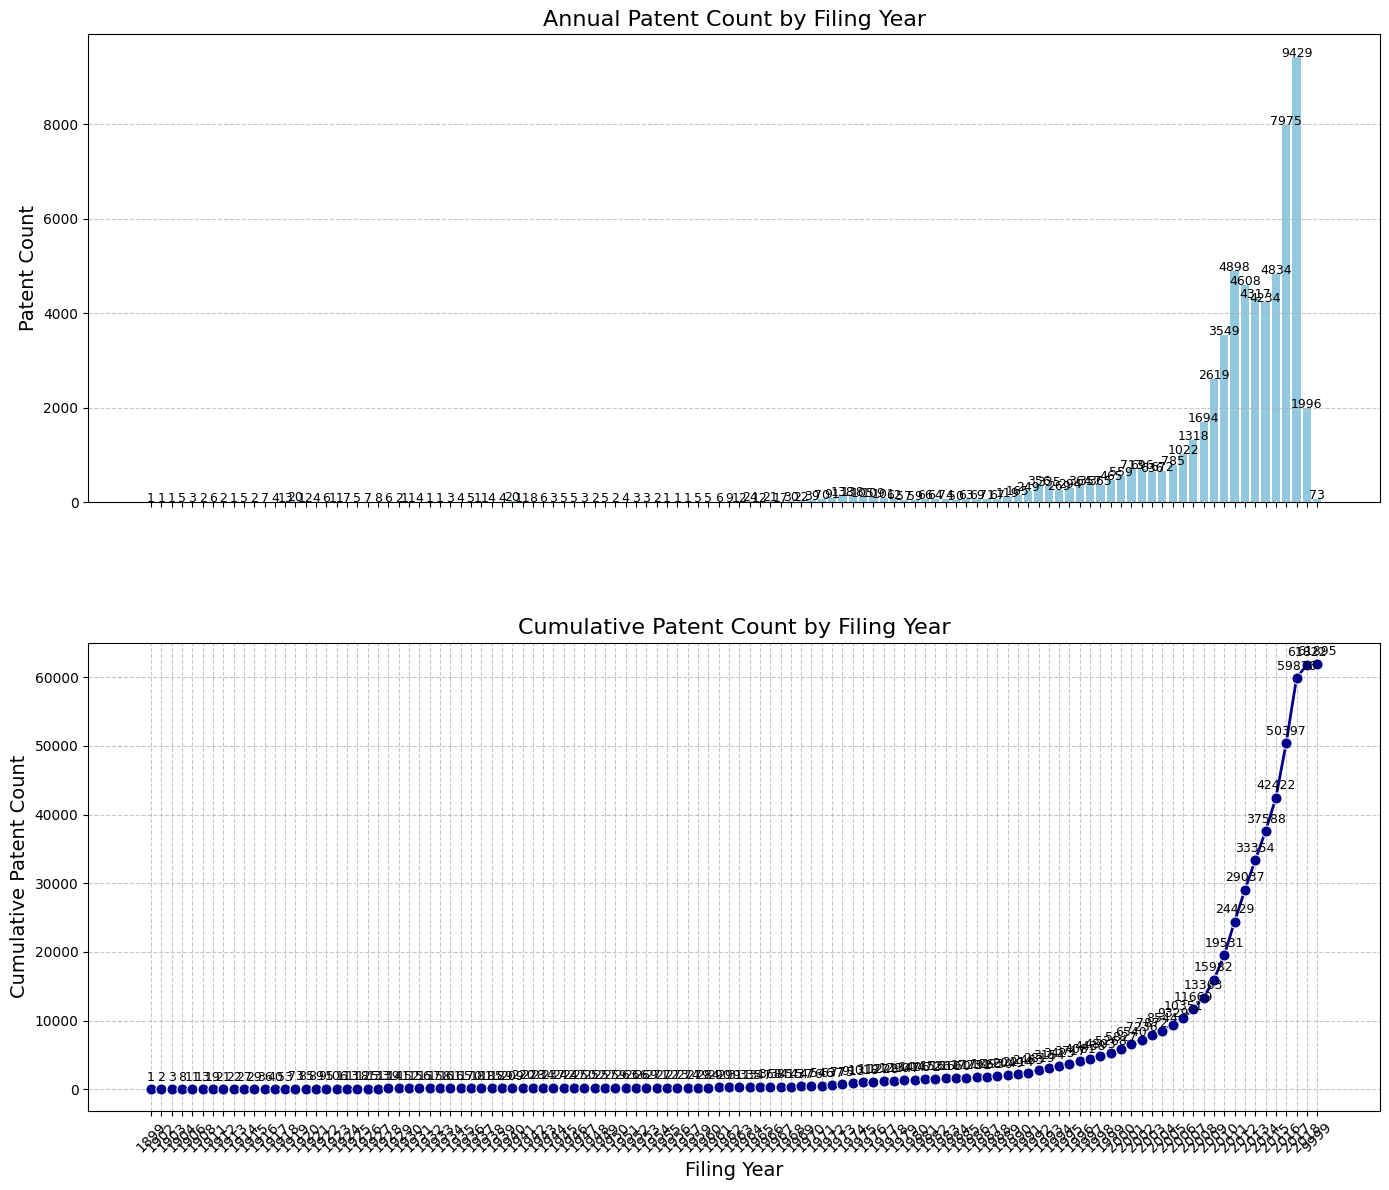

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your DataFrame is named 'df'
# Group by filing_year and count the number of patents each year
yearly_counts = df.groupby('filing_year').size().reset_index(name='patent_count')

# Alternatively, if you want to sum nb_citing_docdb_fam by year:
# yearly_counts = df.groupby('filing_year')['nb_citing_docdb_fam'].sum().reset_index(name='citation_count')

# Sort by year to ensure proper cumulative counting
yearly_counts = yearly_counts.sort_values('filing_year')

# Calculate the cumulative sum
yearly_counts['cumulative_count'] = yearly_counts['patent_count'].cumsum()
# If using citations: yearly_counts['cumulative_count'] = yearly_counts['citation_count'].cumsum()

# Create the figure with two subplots (one for annual, one for cumulative)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot 1: Annual patent count
sns.barplot(x='filing_year', y='patent_count', data=yearly_counts, ax=ax1, color='skyblue')
# If using citations: sns.barplot(x='filing_year', y='citation_count', data=yearly_counts, ax=ax1, color='skyblue')
ax1.set_title('Annual Patent Count by Filing Year', fontsize=16)
ax1.set_ylabel('Patent Count', fontsize=14)
# If using citations: ax1.set_ylabel('Citation Count', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar in the first plot
for i, count in enumerate(yearly_counts['patent_count']):
    ax1.text(i, count + 0.1, str(int(count)), ha='center', fontsize=9)
# If using citations:
# for i, count in enumerate(yearly_counts['citation_count']):
#     ax1.text(i, count + 0.1, str(int(count)), ha='center', fontsize=9)

# Plot 2: Cumulative patent count
sns.lineplot(x='filing_year', y='cumulative_count', data=yearly_counts, ax=ax2, 
             marker='o', color='darkblue', linewidth=2, markersize=8)
ax2.set_title('Cumulative Patent Count by Filing Year', fontsize=16)
# If using citations: ax2.set_title('Cumulative Citation Count by Filing Year', fontsize=16)
ax2.set_xlabel('Filing Year', fontsize=14)
ax2.set_ylabel('Cumulative Patent Count', fontsize=14)
# If using citations: ax2.set_ylabel('Cumulative Citation Count', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add count labels for cumulative plot
for i, (year, count) in enumerate(zip(yearly_counts['filing_year'], yearly_counts['cumulative_count'])):
    ax2.text(i, count + max(yearly_counts['cumulative_count'])*0.02, 
             str(int(count)), ha='center', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Add space between subplots
plt.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your DataFrame is named 'df'
# Group by filing_year and count the number of patents each year
yearly_counts = df.groupby('filing_year').size().reset_index(name='patent_count')

# Alternatively, if you want to sum nb_citing_docdb_fam by year:
# yearly_counts = df.groupby('filing_year')['nb_citing_docdb_fam'].sum().reset_index(name='citation_count')

# Sort by year to ensure proper cumulative counting
yearly_counts = yearly_counts.sort_values('filing_year')

# Calculate the cumulative sum
yearly_counts['cumulative_count'] = yearly_counts['patent_count'].cumsum()

# This DataFrame 'yearly_counts' now contains your cumulative counts per year
print(yearly_counts.head())  # Display the first few rows to verify

# Save to CSV if needed
yearly_counts.to_excel('patent_cumulative_counts_by_year.xlsx', index=False)

  filing_year  patent_count  cumulative_count
0        1899             1                 1
1        1902             1                 2
2        1903             1                 3
3        1904             5                 8
4        1906             3                11


## CITATIONS

In [11]:
sql="""
    SELECT DISTINCT
    SUBSTR(f.earliest_filing_date, 1, 4) AS filing_year,
    f.earliest_filing_id,
    f.fam_ipc_cpc,
    p.nb_citing_docdb_fam
FROM 
    "landscaperdb"."landscaper_family_ext" f
JOIN
     "landscaperdb"."landscaper_patstat_ext" p
ON
    f.earliest_filing_id = p.earliest_filing_id
WHERE
    any_match(f.fam_ipc_cpc, x -> x LIKE '%B60L  11%')
ORDER BY 
    filing_year ASC,
    p.nb_citing_docdb_fam ASC """

db='tmpdatabase' # when querying deda_ingestion_prd_link remember to set tmpdatabase for cache issues
df = wr.athena.read_sql_query(sql=sql,database=db) 
df.head() 

,filing_year,earliest_filing_id,fam_ipc_cpc,nb_citing_docdb_fam
0,2005,48078023,"[A63G 25/00, B60L 9/00, B60L 50/16, B60T ...",244
1,2005,903442978,"[H01M 4/02, H01M 4/131, H01M 4/133, H01M...",252
2,2005,907130881,"[A47L 9/28, G05D 1/02, A63H 11/00, A63H ...",263
3,2005,48078023,"[A63G 25/00, B60L 9/00, B60L 50/16, B60T ...",276
4,2005,907130881,"[A47L 9/28, G05D 1/02, A63H 11/00, A63H ...",299


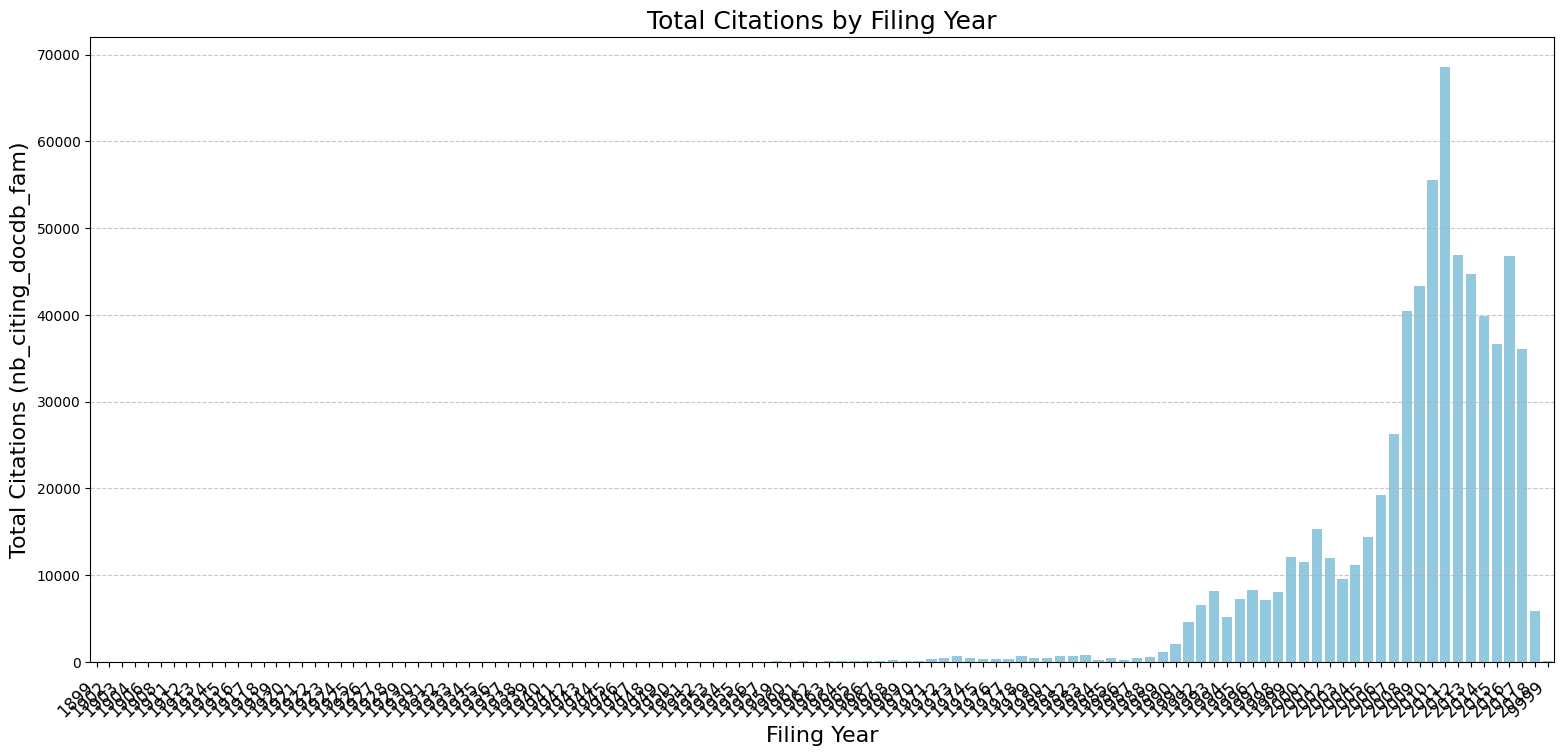

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df'
# Group by filing_year and sum the nb_citing_docdb_fam
yearly_citations = df.groupby('filing_year')['nb_citing_docdb_fam'].sum().reset_index()

# Create the bar graph with a larger figure size
plt.figure(figsize=(16, 8))  # Increased figure width for better spacing

# Create the bar plot
ax = sns.barplot(x='filing_year', y='nb_citing_docdb_fam', data=yearly_citations, color='skyblue')

# Add labels and title
plt.title('Total Citations by Filing Year', fontsize=18)
plt.xlabel('Filing Year', fontsize=16)
plt.ylabel('Total Citations (nb_citing_docdb_fam)', fontsize=16)

# Improve x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotated with horizontal alignment


# Adjust layout
plt.tight_layout(pad=2)  # Added padding
plt.subplots_adjust(bottom=0.15)  # More space at bottom for x labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure x-axis ticks are visible and clear
ax.tick_params(axis='x', labelsize=12, pad=8)  # Increased padding for x-tick labels
plt.setp(ax.get_xticklabels(), visible=True)

plt.show()

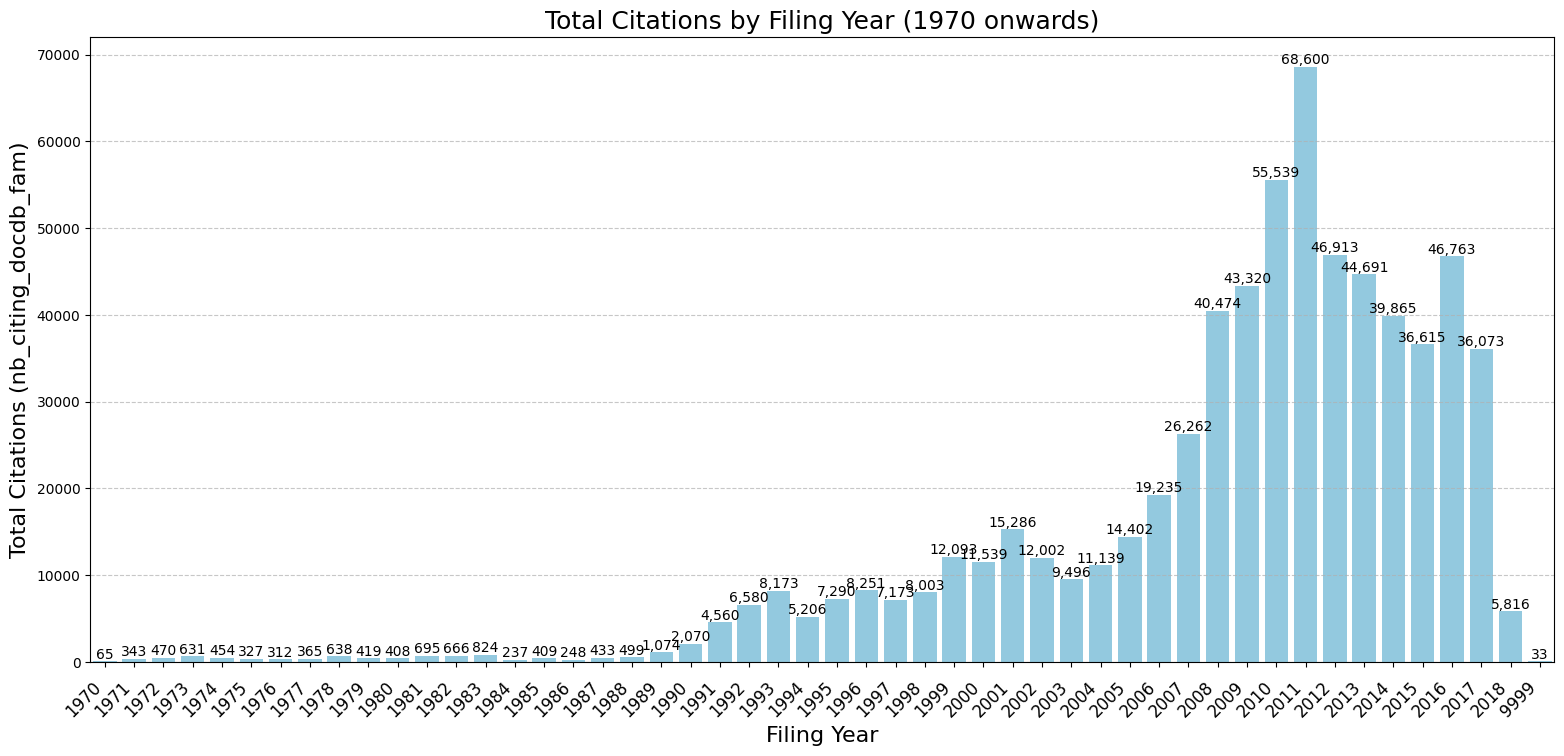

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df'
# Filter for years >= 1970
filtered_df = df[df['filing_year'].astype(int) >= 1970]

# Group by filing_year and sum the nb_citing_docdb_fam
yearly_citations = filtered_df.groupby('filing_year')['nb_citing_docdb_fam'].sum().reset_index()

# Sort by filing_year to ensure chronological order
yearly_citations = yearly_citations.sort_values(by='filing_year')

# Create the bar graph with a larger figure size
plt.figure(figsize=(16, 8))  # Increased figure width for better spacing

# Create the bar plot
ax = sns.barplot(x='filing_year', y='nb_citing_docdb_fam', data=yearly_citations, color='skyblue')

# Add labels and title
plt.title('Total Citations by Filing Year (1970 onwards)', fontsize=18)
plt.xlabel('Filing Year', fontsize=16)
plt.ylabel('Total Citations (nb_citing_docdb_fam)', fontsize=16)

# Improve x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotated with horizontal alignment

# Add count labels on top of each bar (optional but informative)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout(pad=2)  # Added padding
plt.subplots_adjust(bottom=0.15)  # More space at bottom for x labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure x-axis ticks are visible and clear
ax.tick_params(axis='x', labelsize=12, pad=8)  # Increased padding for x-tick labels
plt.setp(ax.get_xticklabels(), visible=True)

plt.show()

## Diffusion Curve

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Load the data from Excel (Sheet2)
#df = pd.read_excel("mercedes/your_file.xlsx", sheet_name="Sheet2")
df = pd.read_excel("mercedes/patent_cumulative_counts_by_year.xlsx", sheet_name="Sheet1")

In [43]:
df

,filing_year,patent_count,cumulative_count
0,1899,1,1
1,1902,1,2
2,1903,1,3
3,1904,5,8
4,1906,3,11
...,...,...,...
109,2015,4834,42422
110,2016,7975,50397
111,2017,9429,59826
112,2018,1996,61822


In [44]:
df = df[df['filing_year'] != 9999] 
df

,filing_year,patent_count,cumulative_count
0,1899,1,1
1,1902,1,2
2,1903,1,3
3,1904,5,8
4,1906,3,11
...,...,...,...
108,2014,4234,37588
109,2015,4834,42422
110,2016,7975,50397
111,2017,9429,59826


In [45]:
df = df[df['filing_year'].astype(int) >= 1970] 
df

,filing_year,patent_count,cumulative_count
64,1970,39,476
65,1971,70,546
66,1972,91,637
67,1973,138,775
68,1974,138,913
69,1975,105,1018
70,1976,109,1127
71,1977,101,1228
72,1978,62,1290
73,1979,57,1347


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit


LOGISTIC MODEL RESULTS:
Estimated Parameters:
L (Carrying Capacity): 123637.9276 ± 22832.5166
k (Growth Rate): 0.1944 ± 0.0141
x0 (Midpoint Year): 2018.0000 ± 1.7506
R-squared: 0.9887

TECHNOLOGY ADOPTION CHARACTERISTICS:
Early Adoption Phase (~10%): Year 2007.71
Inflection Point (50%): Year 2018.00
Late Adoption Phase (~90%): Year 2028.29
Time from 10% to 90% adoption: 20.58 years


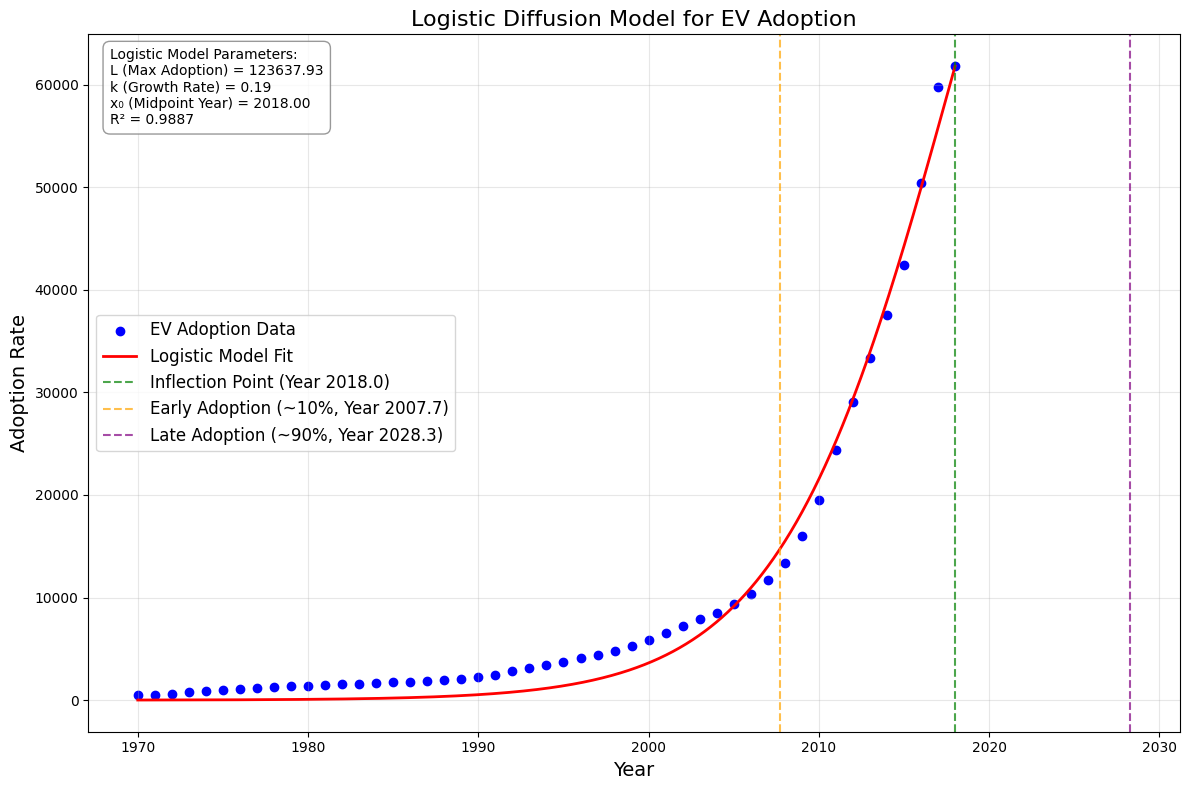

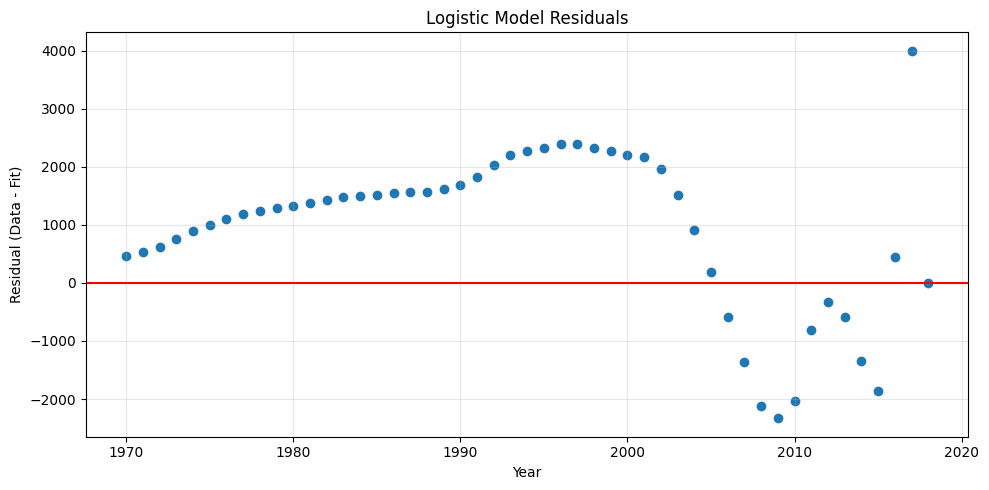


FORECAST FOR FUTURE YEARS:
Year  | Projected Adoption
-----|-------------------
2019  | 67808.2666
2020  | 73686.1763
2021  | 79349.4358
2022  | 84709.8284
2023  | 89698.9302
2024  | 94270.2938
2025  | 98399.1743
2026  | 102080.3096
2027  | 105324.4672
2028  | 108154.4695


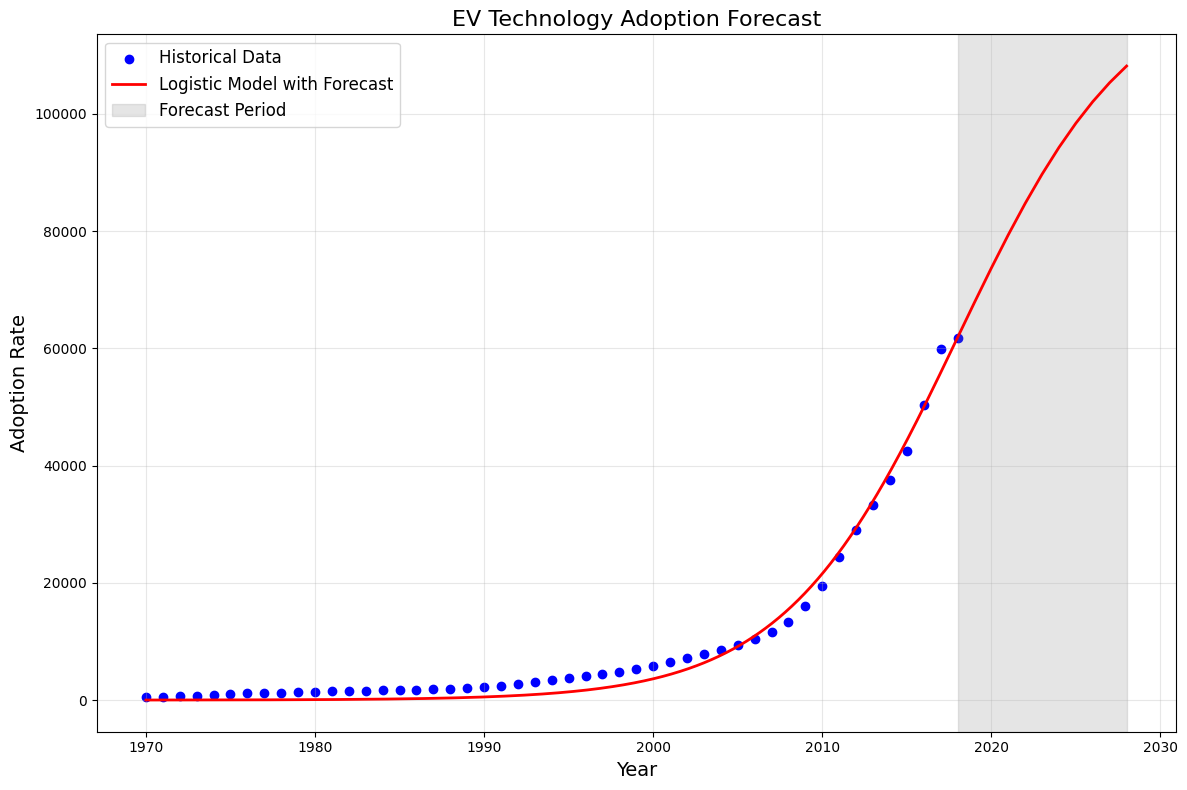

In [48]:
# Replace 'x' and 'y' with the actual column names in your Excel sheet
#x_data = df['x'].values
#y_data = df['y'].values


x_data = df['filing_year'].values
y_data = df['cumulative_count'].values

# Clean data function to remove NaN and inf values
def clean_data(x_data, y_data):
    """Remove any NaN or infinity values from the data"""
    valid_indices = np.isfinite(x_data) & np.isfinite(y_data)
    return x_data[valid_indices], y_data[valid_indices]

# Clean the data
x_data_clean, y_data_clean = clean_data(x_data, y_data)

# Define the logistic function
def logistic_function(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Initial guess for logistic parameters: [L, k, x0]
logistic_initial_guess = [max(y_data_clean), 0.5, np.median(x_data_clean)]

try:
    # Fit logistic model
    logistic_params, logistic_covariance = curve_fit(
        logistic_function, 
        x_data_clean, 
        y_data_clean, 
        p0=logistic_initial_guess,
        bounds=([0, 0, min(x_data_clean)], [np.inf, np.inf, max(x_data_clean)])
    )
    
    # Extract fitted parameters and standard errors for logistic model
    L_fit, k_fit, x0_fit = logistic_params
    logistic_param_errors = np.sqrt(np.diag(logistic_covariance))
    
    # Compute R² for logistic model
    y_fit_logistic = logistic_function(x_data_clean, *logistic_params)
    residuals_logistic = y_data_clean - y_fit_logistic
    ss_res_logistic = np.sum(residuals_logistic**2)
    ss_tot = np.sum((y_data_clean - np.mean(y_data_clean))**2)
    r_squared_logistic = 1 - (ss_res_logistic / ss_tot)
    
    # Create prediction data for plotting a smooth curve
    x_curve = np.linspace(min(x_data_clean), max(x_data_clean), 1000)
    y_curve_logistic = logistic_function(x_curve, *logistic_params)

    # Output results for logistic model
    print("\nLOGISTIC MODEL RESULTS:")
    print("=======================")
    print("Estimated Parameters:")
    print(f"L (Carrying Capacity): {L_fit:.4f} ± {logistic_param_errors[0]:.4f}")
    print(f"k (Growth Rate): {k_fit:.4f} ± {logistic_param_errors[1]:.4f}")
    print(f"x0 (Midpoint Year): {x0_fit:.4f} ± {logistic_param_errors[2]:.4f}")
    print(f"R-squared: {r_squared_logistic:.4f}")
    
    # Calculate inflection points and adoption rate characteristics
    inflection_point = x0_fit  # The inflection point is at x0
    early_adoption_point = x0_fit - (2/k_fit)  # Approx. 10% adoption
    late_adoption_point = x0_fit + (2/k_fit)   # Approx. 90% adoption
    
    print("\nTECHNOLOGY ADOPTION CHARACTERISTICS:")
    print("==================================")
    print(f"Early Adoption Phase (~10%): Year {early_adoption_point:.2f}")
    print(f"Inflection Point (50%): Year {inflection_point:.2f}")
    print(f"Late Adoption Phase (~90%): Year {late_adoption_point:.2f}")
    print(f"Time from 10% to 90% adoption: {late_adoption_point - early_adoption_point:.2f} years")
    
    # Plot fitted curves
    plt.figure(figsize=(12, 8))
    plt.scatter(x_data_clean, y_data_clean, label='EV Adoption Data', color='blue')
    plt.plot(x_curve, y_curve_logistic, 'r-', linewidth=2, label='Logistic Model Fit')
    
    # Mark key points
    plt.axvline(x=inflection_point, color='green', linestyle='--', alpha=0.7, label=f'Inflection Point (Year {inflection_point:.1f})')
    plt.axvline(x=early_adoption_point, color='orange', linestyle='--', alpha=0.7, label=f'Early Adoption (~10%, Year {early_adoption_point:.1f})')
    plt.axvline(x=late_adoption_point, color='purple', linestyle='--', alpha=0.7, label=f'Late Adoption (~90%, Year {late_adoption_point:.1f})')
    
    plt.title('Logistic Diffusion Model for EV Adoption', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Adoption Rate', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add parameter annotation
    annotation_text = f"Logistic Model Parameters:\n" + \
                     f"L (Max Adoption) = {L_fit:.2f}\n" + \
                     f"k (Growth Rate) = {k_fit:.2f}\n" + \
                     f"x₀ (Midpoint Year) = {x0_fit:.2f}\n" + \
                     f"R² = {r_squared_logistic:.4f}"
                     
    plt.annotate(annotation_text, 
                xy=(0.02, 0.98), 
                xycoords='axes fraction',
                va='top',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data_clean, residuals_logistic)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Logistic Model Residuals')
    plt.xlabel('Year')
    plt.ylabel('Residual (Data - Fit)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Generate forecasts for future years
    max_year = max(x_data_clean)
    future_years = np.arange(max_year + 1, max_year + 11)  # 10-year forecast
    
    print("\nFORECAST FOR FUTURE YEARS:")
    print("==========================")
    print("Year  | Projected Adoption")
    print("-----|-------------------")
    
    for year in future_years:
        logistic_forecast = logistic_function(year, *logistic_params)
        print(f"{year}  | {logistic_forecast:.4f}")
    
    # Plot with forecast
    plt.figure(figsize=(12, 8))
    plt.scatter(x_data_clean, y_data_clean, label='Historical Data', color='blue')
    
    forecast_x = np.concatenate([x_curve, future_years])
    forecast_x.sort()
    forecast_y = logistic_function(forecast_x, *logistic_params)
    
    plt.plot(forecast_x, forecast_y, 'r-', linewidth=2, label='Logistic Model with Forecast')
    plt.axvspan(max_year, max(future_years), alpha=0.2, color='gray', label='Forecast Period')
    
    plt.title('EV Technology Adoption Forecast', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Adoption Rate', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in curve fitting: {e}")
    print("Try different initial parameter guesses or check your data.")
    
    # If there's an error, print the data to help diagnose
    print("\nFirst 5 rows of data after cleaning:")
    for i in range(min(5, len(x_data_clean))):
        print(f"x: {x_data_clean[i]}, y: {y_data_clean[i]}")